In [374]:
import pandas as pd
import os
import random
import re 
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

---
#### 0° - Importatin des FUNCTIONS et DATASETS

In [259]:
from scripts.get_INPI_from_SIRENs import getDataINPI

In [526]:
pathData = 'data'
pathFigures = 'figures'

In [261]:
# - Legal Categories Data
legalCategoriesPath = os.path.join(pathData, 'categories-juridiques-insee.csv')
legalCategories = pd.read_csv(legalCategoriesPath, low_memory=False, sep=';')

# Legal Form regarding "Auto-Entrepreneur"
lsForm_AutoEntrepreneur = sorted(list(map(lambda num : legalCategories['Code'].iloc[num], filter(lambda num : legalCategories['Libellé'][num]=='Entrepreneur individuel', range(0, len(legalCategories['Libellé']))))))
print(f'List of FORM regarding "Auto-Entrepreneur" -> {lsForm_AutoEntrepreneur}')

# Display Sample
legalCategories.sample(2)

List of FORM regarding "Auto-Entrepreneur" -> [1, 10, 1000]


,Code,Libellé
89,5646,SA de HLM à directoire
122,6588,Société civile laitière


---
#### 1° - Préparation des Données et Métriques Générales

In [359]:
def countStateInstitutions(data_SI):
    data_SI = data_SI.merge(data_SI.groupby('siren')['siren'].count().reset_index(name='NUM_INSTITUTIONS'), on='siren')
    data_SI_Count = data_SI.groupby(['siren', 'etatAdministratifEtablissement'])['etatAdministratifEtablissement'].count().reset_index(name='count')
    data_SI = data_SI.merge(data_SI_Count[data_SI_Count['etatAdministratifEtablissement']=='A'][['siren', 'count']].rename(columns={'count':'NUM_INSTITUTIONS_ACTIVE'}), on='siren', how='outer')
    data_SI = data_SI.merge(data_SI_Count[data_SI_Count['etatAdministratifEtablissement']=='F'][['siren', 'count']].rename(columns={'count':'NUM_INSTITUTIONS_CLOSE'}), on='siren', how='outer')
    return data_SI[data_SI['etablissementSiege']==True]

In [ ]:
# Read StockUniteLegale Files
path_SE = os.path.join(pathData, 'StockEtablissement', 'SECTION')
path_SUL = os.path.join(pathData, 'StockUniteLegale', 'SECTION')

lsFiles_SE, lsFiles_SUL = os.listdir(path_SE), os.listdir(path_SUL)

db_SE_SUL = pd.DataFrame()  # Database about the STOCK UNITE LEGALE and regarding their EXISTING TIME

# Loop through each Files (Section)
for fileSE, file_SUL in zip(lsFiles_SE, lsFiles_SUL):
    curSection = re.compile("SECTION_(.*)$").search(file_SUL).group(1)[0]
    print(f'Current Section -> "{curSection}"')
    
    df_SE = pd.read_csv(filepath_or_buffer = os.path.join(path_SE, fileSE), index_col = 0, low_memory = False)
    df_SE = countStateInstitutions(df_SE)
    df_SUL = pd.read_csv(filepath_or_buffer = os.path.join(path_SUL, file_SUL), index_col = 0, low_memory = False)
    df_SUL['SECTION'] = curSection
    db_SE_SUL = pd.concat([db_SE_SUL, df_SUL.merge(df_SE, on='siren')])

In [370]:
keepColumns = ['SECTION', 'siren', 'nic', 'siret', 'dateCreationUniteLegale', 'sexeUniteLegale', 'dateDebut_x', 'etatAdministratifUniteLegale',
               'categorieJuridiqueUniteLegale', 'activitePrincipaleUniteLegale', 'nomenclatureActivitePrincipaleUniteLegale',
               'nicSiegeUniteLegale', 'caractereEmployeurUniteLegale', 'codePostalEtablissement', 'libelleCommuneEtablissement', 
               'codeCommuneEtablissement', 'etatAdministratifEtablissement', 'NUM_INSTITUTIONS', 'NUM_INSTITUTIONS_ACTIVE', 'NUM_INSTITUTIONS_CLOSE']
db_comp_SE_SUL = db_SE_SUL[keepColumns]

renameColumns = {'dateDebut_x': 'dateDebut'}
db_comp_SE_SUL = db_comp_SE_SUL.rename(columns=renameColumns)

In [369]:
db_SE_SUL.to_csv(os.path.join(pathData, 'StockEtablissement-StockUniteLegale-FULL.csv'))
db_comp_SE_SUL.to_csv(os.path.join(pathData, 'StockEtablissement-StockUniteLegale-LIGHT.csv'))

---
#### 2° - Moments Clés - Creation/Cessation

In [270]:
def SUL_existingDays(rowInf):
    try:
        if rowInf['etatAdministratifUniteLegale'] == 'C':
            return (datetime.datetime.strptime(rowInf['dateDebut'], '%Y-%m-%d') - datetime.datetime.strptime(rowInf['dateCreationUniteLegale'], '%Y-%m-%d')).days
        return (datetime.datetime.today() - datetime.datetime.strptime(rowInf['dateCreationUniteLegale'], '%Y-%m-%d')).days
    except:
        return None

In [371]:
db_comp_SE_SUL.sample(2)

,SECTION,siren,nic,siret,dateCreationUniteLegale,sexeUniteLegale,dateDebut,etatAdministratifUniteLegale,categorieJuridiqueUniteLegale,activitePrincipaleUniteLegale,nomenclatureActivitePrincipaleUniteLegale,nicSiegeUniteLegale,caractereEmployeurUniteLegale,codePostalEtablissement,libelleCommuneEtablissement,codeCommuneEtablissement,etatAdministratifEtablissement,NUM_INSTITUTIONS,NUM_INSTITUTIONS_ACTIVE,NUM_INSTITUTIONS_CLOSE
763779,F,530560705,10,53056070500010,2011-02-14,NaN,2015-04-29,C,5499.0,43.21A,NAFRev2,10,N,45200.0,MONTARGIS,45208,F,1,NaN,1.0
226925,L,348761123,10,34876112300010,1988-10-05,NaN,2008-01-01,A,6540.0,68.20B,NAFRev2,10,N,77590.0,BOIS-LE-ROI,77037,A,1,1.0,NaN


In [372]:
db_comp_SE_SUL['DAYS_SCREATION'] = db_comp_SE_SUL.apply(lambda row : SUL_existingDays(row), axis=1)
db_comp_SE_SUL[['SECTION', 'etatAdministratifUniteLegale', 'DAYS_SCREATION']].sample(5)

,SECTION,etatAdministratifUniteLegale,DAYS_SCREATION
452931,S,C,4842.0
441674,L,A,10827.0
477634,A,A,14661.0
661111,A,A,6336.0
175596,G,A,12018.0


In [396]:
db_comp_SE_SUL['DAYS_SCREATION_PRCT'] = db_comp_SE_SUL['DAYS_SCREATION'] / np.nansum(db_comp_SE_SUL['DAYS_SCREATION'])
db_comp_SE_SUL[['SECTION', 'etatAdministratifUniteLegale', 'DAYS_SCREATION', 'DAYS_SCREATION_PRCT']].sample(5)

,SECTION,etatAdministratifUniteLegale,DAYS_SCREATION,DAYS_SCREATION_PRCT
793381,Q,A,2037.0,2.220517e-08
807971,L,A,18672.0,2.035420e-07
665244,N,A,3044.0,3.318240e-08
647330,I,A,1105.0,1.204552e-08
1488471,F,A,287.0,3.128564e-09


In [397]:
db_comp_SE_SUL.to_csv(os.path.join(pathData, 'StockEtablissement-StockUniteLegale-LIGHT-UPDT1.csv'))

##### -> Distribution VS Section & Administrative State

In [501]:
db_DSAS = db_comp_SE_SUL.copy()
db_DSAS['SECTION'] = db_DSAS.SECTION.apply(lambda section_ : f'SECTION {section_}')
db_DSAS = db_DSAS.groupby(['SECTION', 'etatAdministratifUniteLegale'])['SECTION'].count().reset_index(name='NUM_OBSERVATIONS')
db_DSAS['PERCENTAGE_OBSERVATIONS'] = (db_DSAS.NUM_OBSERVATIONS / np.nansum(db_DSAS.NUM_OBSERVATIONS) * 100)
db_DSAS['etatAdministratifUniteLegale'] = np.where(db_DSAS['etatAdministratifUniteLegale']=='A', 'Active', 'Closed')
db_DSAS.sample(3)

,SECTION,etatAdministratifUniteLegale,NUM_OBSERVATIONS,PERCENTAGE_OBSERVATIONS
1,SECTION A,Closed,246637,1.392216
34,SECTION R,Active,677164,3.822453
17,SECTION I,Closed,254219,1.435015


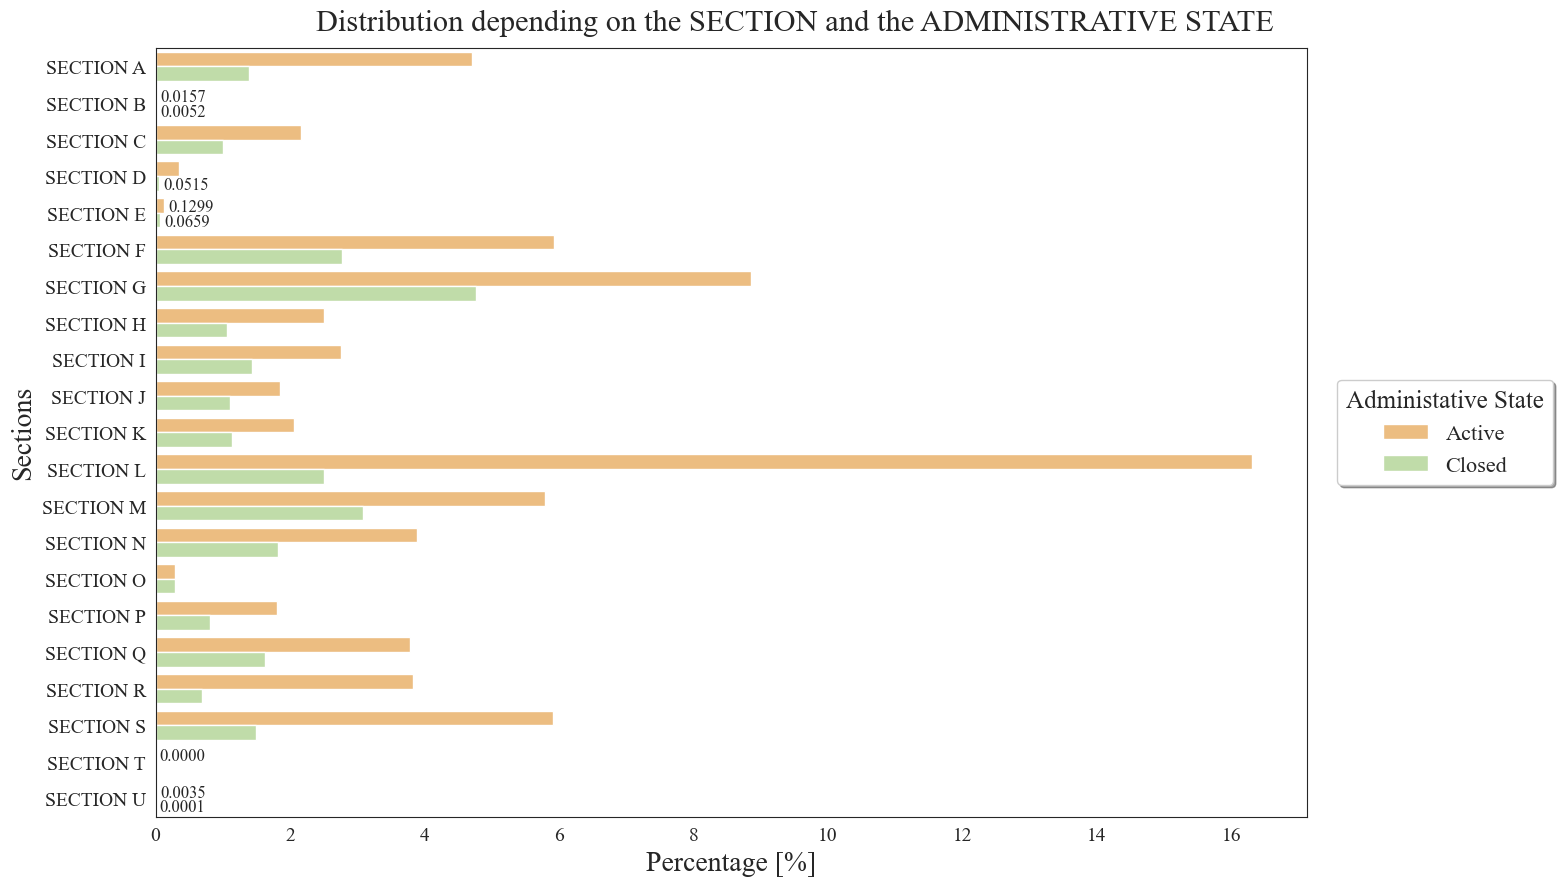

In [527]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

# Axis
order_axis = db_DSAS.SECTION.sort_values(ascending=True).unique().tolist()
order_hue = db_DSAS.etatAdministratifUniteLegale.sort_values(ascending=True).unique().tolist()
ax = sns.barplot(x = "PERCENTAGE_OBSERVATIONS", y = "SECTION", data = db_DSAS, hue = "etatAdministratifUniteLegale", hue_order=order_hue, palette = "Spectral", errorbar=('ci', 68), capsize= 0.05)
ax.set_xlabel("Percentage [%]", size=20)
ax.set_ylabel("Sections", size=20)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':16, 'family': 'Times New Roman' }, labelspacing=0.5)
leg.set_title('Administative State', prop = {'size': 18, 'family':'Times New Roman'})

# Annotation
for p in ax.patches:
    if p.get_width() < 0.2: 
        _x = p.get_x() + p.get_width() + 0.40
        _y = p.get_y() + p.get_height() - 0.05
        value = '{:.4f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="center", fontsize = 12, fontname = "Times New Roman") 


#Figure
fig.suptitle("Distribution depending on the SECTION and the ADMINISTRATIVE STATE", ha = 'center', size=22)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
pathFile = os.path.join(pathFigures, 'Création & Cessation - Unité Légale', "Barplots - Distribution on SECTION & ADMINISTRATIVE STATE")
os.makedirs(os.path.dirname(pathFile), exist_ok=True)
fig.savefig(pathFile)

##### -> DAYS since UNITE Creation

In [430]:
#Function to display the values above the barplots.
def show_values_on_bars(axs, width, height):
    def _show_on_single_plot(ax, width, height):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / width
            _y = p.get_y() + p.get_height() + height
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize = 18, fontname = "Times New Roman") 

    if isinstance(axs, np.ndarray):
        for _, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax, width, height)
    else:
        _show_on_single_plot(axs, width, height)

In [450]:
db_comp_SE_SUL_BIS = db_comp_SE_SUL.copy()
db_comp_SE_SUL_BIS['DAYS_SCREATION_PRCT'] = db_comp_SE_SUL_BIS['DAYS_SCREATION'] / np.nansum(db_comp_SE_SUL_BIS['DAYS_SCREATION'])
db_comp_SE_SUL_BIS[['SECTION', 'etatAdministratifUniteLegale', 'DAYS_SCREATION', 'DAYS_SCREATION_PRCT']].sample(5)
db_comp_SE_SUL_BIS = db_comp_SE_SUL_BIS.groupby(['SECTION', 'etatAdministratifUniteLegale'])['DAYS_SCREATION_PRCT'].sum().reset_index()
db_comp_SE_SUL_BIS.sample(3)


,SECTION,etatAdministratifUniteLegale,DAYS_SCREATION_PRCT
9,E,C,0.000742
8,E,A,0.001376
6,D,A,0.002380


In [454]:
db_comp_SE_SUL_BIS

,SECTION,etatAdministratifUniteLegale,DAYS_SCREATION_PRCT
0,A,A,8.066883e-02
1,A,C,1.788814e-02
2,B,A,2.901189e-04
3,B,C,8.137527e-05
4,C,A,2.332494e-02
5,C,C,8.951240e-03
6,D,A,2.379579e-03
7,D,C,2.677354e-04
8,E,A,1.375875e-03
9,E,C,7.421896e-04


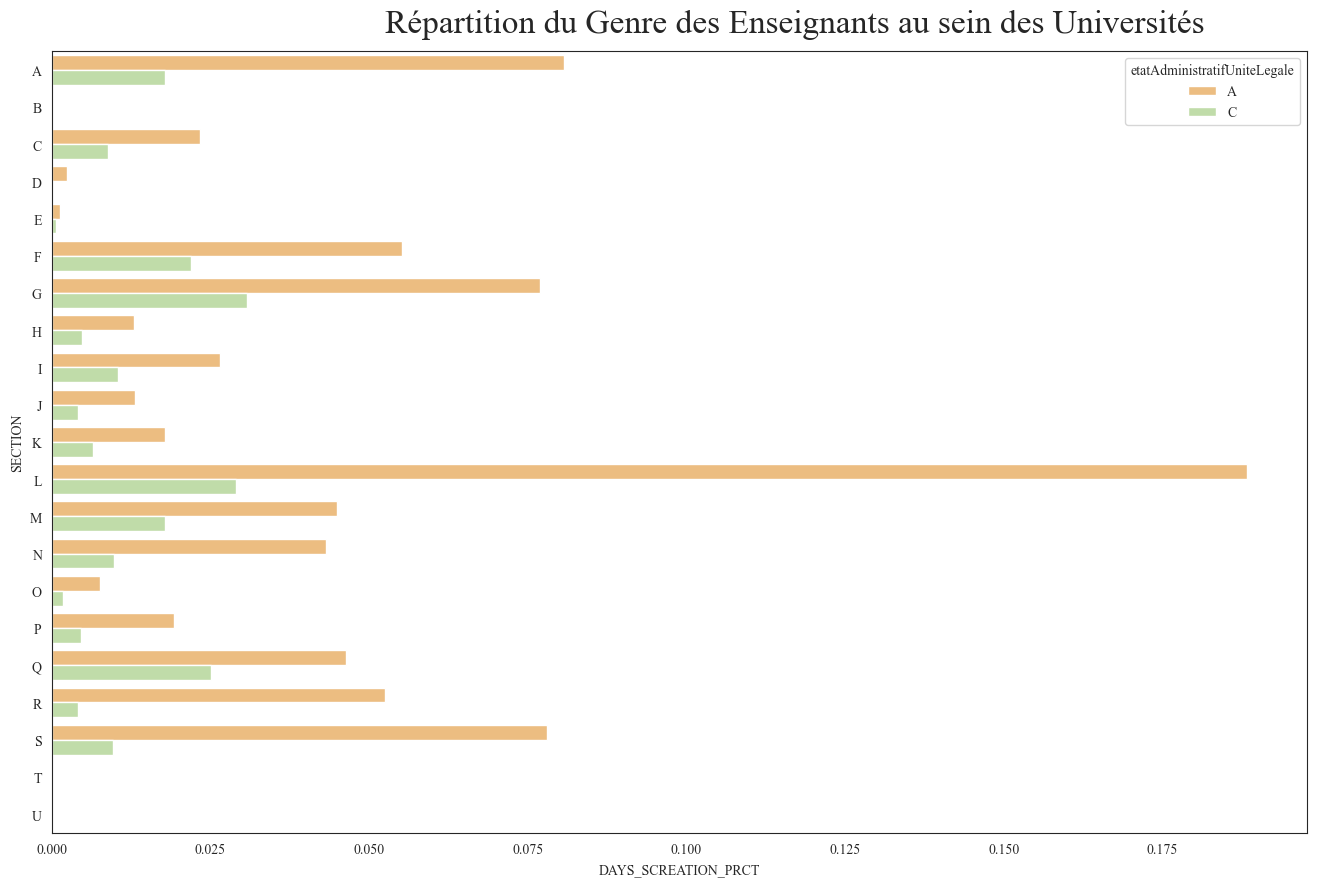

In [457]:
#Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rc('font',family='Times New Roman')

#Axis
order_axis = db_comp_SE_SUL_BIS.SECTION.sort_values(ascending=True).unique().tolist()
order_gender = ["Femme", "Homme", "Non Spécifié"]
ax = sns.barplot(x = "DAYS_SCREATION_PRCT", y = 'SECTION', data = db_comp_SE_SUL_BIS, hue = "etatAdministratifUniteLegale", hue_order=['A', 'C'], palette = "Spectral", errorbar=('ci', 68), capsize= 0.05)
# ax.set_xlabel("Nom de l'Université", size=24)
# ax.set_ylabel("Pourcentage [%]", size=24)
# plt.setp(ax.get_xticklabels(), fontsize=20)
# plt.setp(ax.get_yticklabels(), fontsize=20)
# leg = ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5), shadow=True, prop={'size':20, 'family': 'Times New Roman' }, labelspacing=0.5)
# leg.set_title('Genre', prop = {'size': 24, 'family':'Times New Roman'})
# show_values_on_bars(ax, 1.5, 0.05)
# plt.ylim([0, 1]) #Set the y-axis lim

#Figure
fig.suptitle("Répartition du Genre des Enseignants au sein des Universités", ha = 'center', size=24)
fig.tight_layout()
fig.subplots_adjust(right=0.82)

#Save Figure
# fig.savefig(path_figures + "Barplots - Rprt Genre Universites")